In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


- Plot Data:
    - Candle Plots
    - Volume
    - Target
    - Return
    - Missing values
    - Timestamps
- Correlation
- Time searies analysis
    - Autocorrelation
    - Seasonality/Trend
    

In [4]:
import os
import random
import gresearch_crypto
import pdb

TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/train.csv'
ASSET_DETAILS_CSV = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

SEED = 2021

REMOVE_LB_TEST_OVERLAPPING_DATA = True

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

fix_all_seeds(SEED)

In [5]:
df_train = pd.read_csv(TRAIN_CSV)
display(df_train.head())
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")
display(df_asset_details)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


In [6]:
def calculate_target(data: pd.DataFrame, details: pd.DataFrame, price_column: str):
    ids = list(details.Asset_ID)
    asset_names = list(details.Asset_Name)
    weights = np.array(list(details.Weight))

    all_timestamps = np.sort(data['timestamp'].unique())
    targets = pd.DataFrame(index=all_timestamps)

    for i, id in enumerate(ids):
        asset = data[data.Asset_ID == id].set_index(keys='timestamp')
        price = pd.Series(index=all_timestamps, data=asset[price_column])
        targets[asset_names[i]] = (
            price.shift(periods=-16) /
            price.shift(periods=-1)
        ) - 1
    
    targets['m'] = np.average(targets.fillna(0), axis=1, weights=weights)
    
    m = targets['m']

    num = targets.multiply(m.values, axis=0).rolling(3750).mean().values
    denom = m.multiply(m.values, axis=0).rolling(3750).mean().values
    beta = np.nan_to_num(num.T / denom, nan=0., posinf=0., neginf=0.)

    targets = targets - (beta * m.values).T
    targets.drop('m', axis=1, inplace=True)
    
    return targets



# define function to compute log returns
def log_return(series, periods=1):
    # Copied from https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
    return np.log(series).diff(periods=periods)


In [7]:
# targets = calculate_target(df_train, df_asset_details, "Close")
# print(type(targets), targets.shape)
# targets.head()

In [8]:
# Remove the future
if REMOVE_LB_TEST_OVERLAPPING_DATA:
    df_train['datetime'] = pd.to_datetime(df_train['timestamp'], unit='s')
    df_train = df_train[df_train['datetime'] < '2021-06-13 00:00:00']

In [9]:
# This implementation trains one model per asset. 
# Another approach would be to train one model for all the data points. 


# Xs = {}
# ys = {}
# models = {}
# 
# for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
#     print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
#     
#     df_asset = df_train[df_train["Asset_ID"] == asset_id]
#     X, y, model = get_trained_model(df_asset)    
#     Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model

In [10]:
display(df_train.dtypes)
display(df_train.isna().sum())
df_train.describe()

timestamp             int64
Asset_ID              int64
Count               float64
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
VWAP                float64
Target              float64
datetime     datetime64[ns]
dtype: object

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       748603
datetime          0
dtype: int64

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.222169e+07,2.222169e+07,2.222169e+07,2.222169e+07,2.222169e+07,2.222169e+07,2.222169e+07,2.222169e+07,2.222168e+07,2.147309e+07
mean,1.572519e+09,6.273809e+00,2.656109e+02,1.253428e+03,1.257147e+03,1.250397e+03,1.253427e+03,2.821549e+05,NaN,7.563588e-06
std,3.081225e+07,4.096789e+00,8.446515e+02,5.405991e+03,5.416120e+03,5.396510e+03,5.405995e+03,2.507257e+06,NaN,5.789194e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.546426e+09,3.000000e+00,1.800000e+01,2.436415e-01,2.441000e-01,2.430000e-01,2.436350e-01,1.407652e+02,2.436300e-01,-1.731443e-03
50%,1.573420e+09,6.000000e+00,5.700000e+01,1.337890e+01,1.340000e+01,1.335800e+01,1.337870e+01,1.290990e+03,1.337759e+01,-4.030310e-05
75%,1.599604e+09,9.000000e+00,1.970000e+02,2.134075e+02,2.139500e+02,2.130200e+02,2.134075e+02,2.466952e+04,2.134037e+02,1.642041e-03
max,1.623542e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [11]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218,2018-01-01 00:01:00
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399,2018-01-01 00:01:00
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922,2018-01-01 00:01:00
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264,2018-01-01 00:01:00


In [12]:
df_btc = df_train[df_train["Asset_ID"]==1].copy()

In [13]:
df_btc['timestamp'] = df_btc['timestamp'].astype('datetime64[s]')
# df_btc["datetime"] = pd.to_datetime(df_btc["timestamp"], unit="s")
df_btc = df_btc.set_index("timestamp").sort_index()


In [14]:
(df_btc.index[1:]-df_btc.index[:-1]).value_counts()


0 days 00:01:00    1812141
0 days 00:02:00         75
0 days 00:03:00         12
0 days 00:04:00         11
0 days 00:07:00          9
0 days 00:06:00          4
0 days 00:10:00          4
0 days 00:08:00          3
0 days 00:12:00          3
0 days 00:14:00          3
0 days 00:05:00          3
0 days 00:09:00          2
0 days 00:27:00          2
0 days 00:30:00          2
0 days 00:18:00          2
0 days 00:37:00          1
0 days 00:11:00          1
0 days 00:26:00          1
0 days 00:17:00          1
0 days 00:20:00          1
0 days 00:40:00          1
0 days 00:24:00          1
Name: timestamp, dtype: int64

In [15]:
df_btc.head(2)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
timestamp,,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00


In [16]:
df_btc_daily = df_btc[["Open"]].resample("D").first()
df_btc_daily["Close"] = df_btc[["Close"]].resample("D").last()
df_btc_daily["High"] = df_btc[["High"]].resample("D").max()
df_btc_daily["Low"] = df_btc[["Low"]].resample("D").min()
df_btc_daily["Volume"] = df_btc[["Volume"]].resample("D").sum()
df_btc_daily["Count"] = df_btc[["Count"]].resample("D").sum()
df_btc_daily["Count"] = df_btc[["Count"]].resample("D").sum()
# df_btc_daily["Open"] = df_btc[["Open","datetime"]].resample("D", on="datetime").first()["Open"]
df_btc_daily["datetime"] = pd.to_datetime(df_btc_daily.index, unit="s")
df_btc_daily["daily_lret"] = log_return(df_btc_daily["Close"].copy(), periods=1)


df_btc_daily.head()

,Open,Close,High,Low,Volume,Count,datetime,daily_lret
timestamp,,,,,,,,
2018-01-01,13835.194,13432.918,14442.9,12750.00,57823.038455,365257.0,2018-01-01,NaN
2018-01-02,13427.492,14746.112,15500.0,12798.00,105520.435396,574564.0,2018-01-02,0.093271
2018-01-03,14748.296,15101.994,15599.7,14150.00,83836.040636,518239.0,2018-01-03,0.023847
2018-01-04,15102.012,15154.760,15500.1,13918.04,101131.761732,565945.0,2018-01-04,0.003488
2018-01-05,15154.766,16949.880,17200.0,14600.00,108707.001143,595440.0,2018-01-05,0.111946


In [17]:
df_btc_daily["Close"].max()

63570.902857142864

In [18]:
def plot_candles(df):
    # Create subplots and mention plot grid size
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                   vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
                   row_width=[0.2, 0.7])

    # Plot OHLC on 1st row
    fig.add_trace(go.Candlestick(x=df["datetime"], open=df["Open"], high=df["High"],
                    low=df["Low"], close=df["Close"], name="OHLC"), 
                    row=1, col=1
    )

    # Bar trace for volumes on 2nd row without legend
    fig.add_trace(go.Bar(x=df['datetime'], y=df['Volume'], showlegend=False), row=2, col=1)

    # Do not show OHLC's rangeslider plot 
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()
    


In [57]:
# plot_candles(df_btc_daily)
df = df_btc_daily.copy()
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df["datetime"], open=df["Open"], high=df["High"],
                low=df["Low"], close=df["Close"], name="OHLC"), 
                row=1, col=1
)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df['datetime'], y=df['Volume'], showlegend=False), row=2, col=1)

# Do not show OHLC's rangeslider plot 
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [19]:
def plot_returns(train_daily):
    if "timestamp" not in train_daily.columns:
        train_daily["timestamp"] = train_daily.index

    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

    sns.lineplot(data=train_daily, x='timestamp', y ='Close' , ax=ax[0]);
    sns.lineplot(data=train_daily, x='timestamp', y ='daily_lret' , ax=ax[1]);
    ax[0].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
    ax[0].set_ylim([0, 20000])

    ax[1].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
    ax[1].annotate('COVID-19', xy=(pd.Timestamp('2020-03-15'), -0.5),  xycoords='data',
                xytext=(0.6, 0.2), textcoords='axes fraction',
                arrowprops=dict(facecolor='black', shrink=0.05, width=1),
                #horizontalalignment='right', verticalalignment='top',
                )
    plt.show()

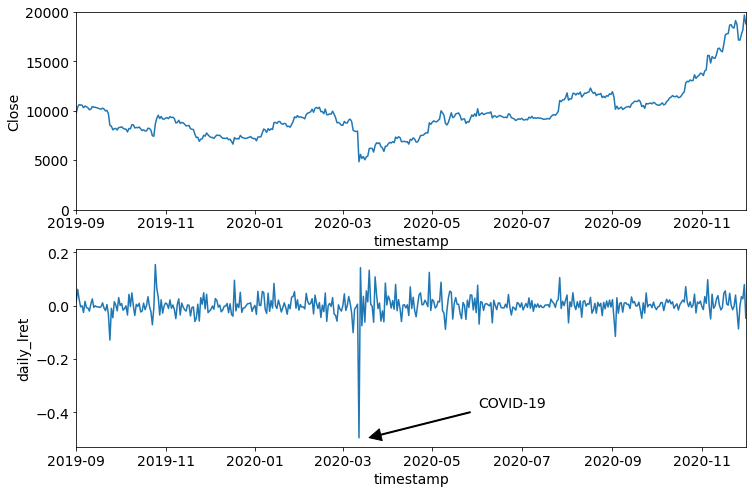

In [20]:
plot_returns(df_btc_daily)

In [21]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def adfuller_test(series):
    X = series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
    

In [24]:
adfuller_test(df_btc_daily["Close"])
adfuller_test(df_btc_daily["daily_lret"].fillna(0))

ADF Statistic: -0.495662
p-value: 0.892860
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary
ADF Statistic: -24.502466
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


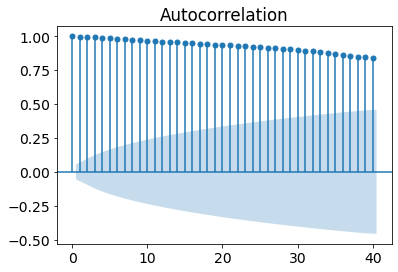

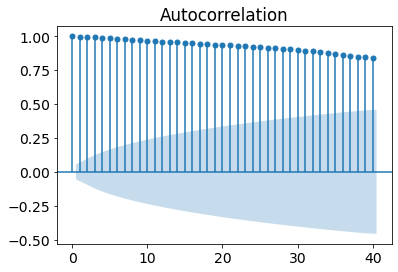

In [26]:
plot_acf(df_btc_daily["Close"].values.squeeze(), lags=40)


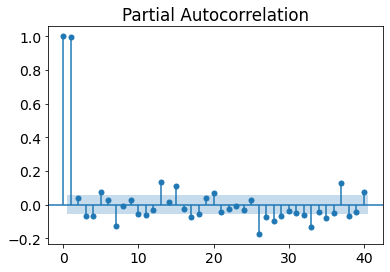

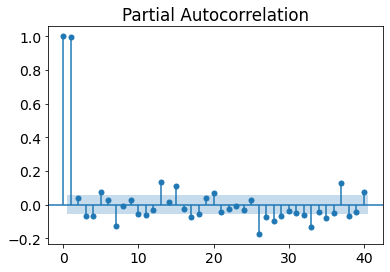

In [27]:
plot_pacf(df_btc_daily["Close"], lags=40)